How to train a a Neural Network?

1. Randomly initialize the weights
2. Implement forward propagation to get h for any x
3. Implement the cost function
4. Implement backpropagation to compute partial derivatives
5. Use gradient checking to confirm that your backpropagation works. Then disable gradient checking.
6. Use gradient descent or a built-in optimization function to minimize the cost function with the weights in theta.
7. When we perform forward and back propagation, we loop on every training example


In [1]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy import optimize as op
import scipy.io as sio

Let's load the data

In [2]:
data = sio.loadmat('./data/ex4data1.mat')

In [3]:
X = data['X']
X.shape

(5000, 400)

In [4]:
y = data['y'].reshape(len(data['y']))
y.shape

(5000,)

y needs to be encoded

In [5]:
def encode_y(y, K):
    m = len(y)
    y_encoded = np.zeros((m, K))
    for i in range(m):
        y_encoded[i,y[i]-1] = 1
    return y_encoded    

In [6]:
y_encoded = encode_y(y, 10)
y_encoded.shape

(5000, 10)

In [7]:
print(y_encoded[1000], y[1000])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 2


In [8]:
def show_image(x):
    digit = x.reshape(20,20, order='F')
    plt.imshow(digit, cmap='gray')
    plt.show()

2


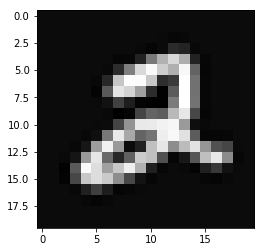

In [9]:
print(y[1000])
show_image(X[1000])

Architecture:  
Fully connected
- 1 input layer with 400 + 1 units
- 1 hidden layer with 25 + 1 untis
- 1 output layer with 10 units


Inital theta

In [12]:
theta = sio.loadmat('./data/ex4weights.mat')
theta1 = np.array(theta['Theta1'])
theta2 = np.array(theta['Theta2'])
theta = np.append(theta1, theta2)

In [13]:
theta1.shape

(25, 401)

In [14]:
theta2.shape

(10, 26)

Cost function

In [15]:
def sigmoid(x):                                        
    return 1.0 / (1 + np.exp(-x))  

In [16]:
def h(theta1, theta2, x):
    z2 = theta1 @ x
    a2 = sigmoid(z2)
    
    #bias
    a2 = np.insert(a2, 0, 1, axis=0)
    
    z3 = theta2 @ a2
    a3 = sigmoid(z3)
    
    return a3, z3, a2, z2

In [17]:
def compute_cost_one_obs(theta1, theta2, y, x):
    k = - y * np.log(h(theta1, theta2, x)[0]) - (1 - y) *  np.log(1 - h(theta1, theta2, x)[0])
    return k.sum()

In [18]:
# set lambda_ to zero for no regulation
def cost_function(theta, y, X, 
                     input_layer_size = 400,
                     hidden_layer_size = 25,
                     output_layer_size = 10,
                     lambda_ = 1):
    
    m = X.shape[0]
    
    # unroll and reshape theta
    theta1 = theta[0:((input_layer_size+1)*hidden_layer_size)]
    theta1 = theta1.reshape(hidden_layer_size, input_layer_size+1)
    
    theta2 = theta[(input_layer_size+1)*hidden_layer_size:]
    theta2 = theta2.reshape(output_layer_size, hidden_layer_size+1)
    
    # intercept
    intercept = np.ones((m, 1))
    X = np.hstack((intercept, X))
    
    cost = 0

    for i in range(m):
        cost = cost + compute_cost_one_obs(theta1, theta2, y[i], X[i])
    
    reg = np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2)

    cost = (cost/m) + (lambda_/(2*m)) * reg
    #print(cost)
    return cost

In [19]:
# match with exo 1.3
print(cost_function(theta, y_encoded, X, lambda_=0))
# match with exo 1.4
print(cost_function(theta, y_encoded, X, lambda_=1))

0.28762916516131887
0.3837698590909236


Random initialization. Important, else the parameters are symmetric

In [22]:
def random_theta(L_output, L_input, epsilon = 0.12):
    W = np.random.rand(L_output, L_input + 1)
    return W * 2 * epsilon - epsilon

In [23]:
theta0 = np.append(random_theta(25,400), random_theta(10,25))
theta0.shape

(10285,)

Gradient

In [24]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1-sigmoid(z))

In [25]:
def gradient(theta, y, X,
                input_layer_size = 400,
                hidden_layer_size = 25,
                output_layer_size = 10):
    
    m = X.shape[0]
    
    # unroll theta
    theta1 = theta[0:((input_layer_size+1)*hidden_layer_size)]
    theta1 = theta1.reshape(hidden_layer_size, input_layer_size+1)
    
    theta2 = theta[(input_layer_size+1)*hidden_layer_size:]
    theta2 = theta2.reshape(output_layer_size, hidden_layer_size+1)
   
    # intercept
    intercept = np.ones((m, 1))
    X = np.hstack((intercept, X))
    
    # intialise gradient to 0
    grad_theta1 = np.zeros([hidden_layer_size, input_layer_size+1])
    grad_theta2 = np.zeros([output_layer_size, hidden_layer_size+1])
    
    for i in range(m):
        a1 = X[i]
        # steps 1: forward propagation
        a3, z3, a2, z2 = h(theta1, theta2, X[i])
        z2 = np.insert(z2, 0, 1)
        
        # step 2: 'error' output layer       
        delta3 = a3 - y[i]

        # step 3: 'error' hidden layer 
        
        g2 = sigmoid_gradient(z2) 
        delta2 = (theta2.T @ delta3) * g2
           
        # step 4: accumulator
        grad_theta1 = grad_theta1 + (np.reshape(delta2[1:], (len(delta2[1:]),1)) * np.reshape(a1, (len(a1),1)).T)
        grad_theta2 = grad_theta2 + (np.reshape(delta3, (len(delta3),1)) * np.reshape(a2, (len(a2),1)).T)
        
    grad_theta = np.append(grad_theta1, grad_theta2) / m

    return grad_theta

In [27]:
#  debug :-)
gradient(theta0, y_encoded, X).shape

(10285,)

Gradient checking  

In [28]:
def gradient_check(theta, y, X):  
    n = theta.shape[0]
    e = 1e-4
    
    to_check = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    
    grad = gradient(theta, y, X)
    
    for i in range(n):
        perturb[i] = e
        loss1 = cost_function((theta - perturb), y, X)
        loss2 = cost_function((theta + perturb), y, X)
        numerical_gradient = (loss2 - loss1) / (2*e)
        to_check[i] = numerical_gradient
        perturb[i] = 0        
        
        print('---')
        print(to_check[i] - grad[i])

        if i == 5:
            break
        
    return grad, to_check

Should be implemented for smaller network, but looks OK. To check, why not for first result?

In [30]:
a = gradient_check(theta0, y, X)

---
14.055743036996203
---
-2.5568169803591445e-06
---
-1.6638068700558506e-05
---
7.937265159815873e-06
---
-2.9369112943884618e-05
---
-6.427457031390083e-05


Neural network

In [31]:
def neural_network(theta, y, X):
    result = op.minimize(fun=cost_function, x0=theta, args=(y, X), 
                         method='TNC', jac=gradient, options={'maxiter':100})
    return result.x

In [32]:
optimal_theta = neural_network(theta0, y_encoded, X)

In [33]:
def predict(theta, x): 
    input_layer_size = 400
    hidden_layer_size = 25
    output_layer_size, L = 10, 10
    
    theta1 = theta[0:((input_layer_size+1)*hidden_layer_size)]
    theta1 = theta1.reshape(hidden_layer_size, input_layer_size+1)
    
    theta2 = theta[(input_layer_size+1)*hidden_layer_size:]
    theta2 = theta2.reshape(output_layer_size, hidden_layer_size+1)
    
    # intercept
    x = np.insert(x, 0, 1)
    
    a3 = h(theta1, theta2, x)[0]
    y = np.argmax(a3) + 1
    
    return y

In [34]:
y_pred = np.array([predict(optimal_theta, i) for i in X])

In [35]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98       500
           2       0.97      0.96      0.96       500
           3       0.95      0.95      0.95       500
           4       0.96      0.98      0.97       500
           5       0.96      0.96      0.96       500
           6       0.98      0.98      0.98       500
           7       0.96      0.97      0.96       500
           8       0.96      0.97      0.97       500
           9       0.96      0.94      0.95       500
          10       0.99      0.99      0.99       500

   micro avg       0.97      0.97      0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



Have a look at what's happening inside network;

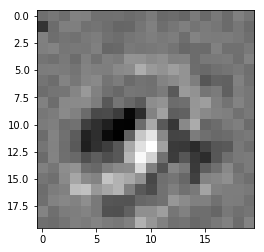

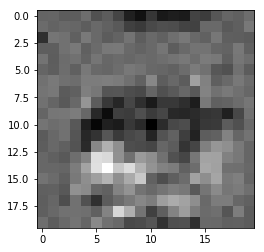

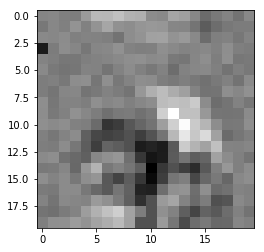

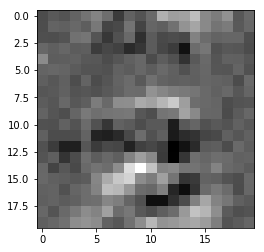

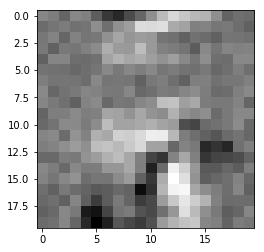

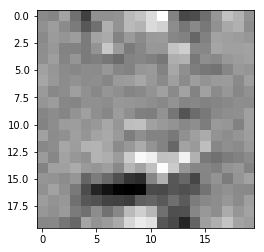

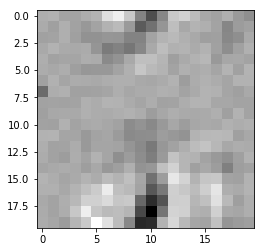

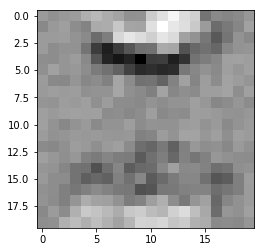

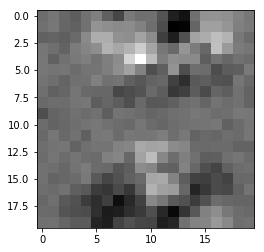

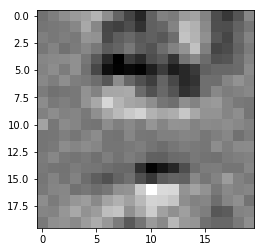

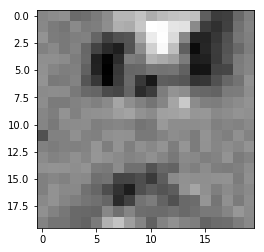

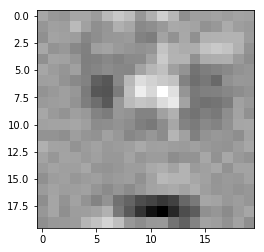

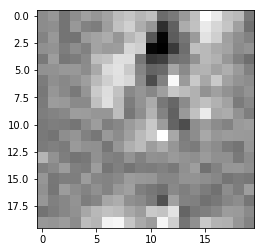

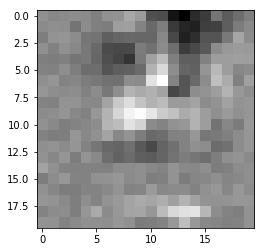

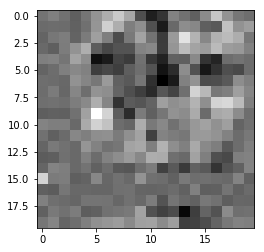

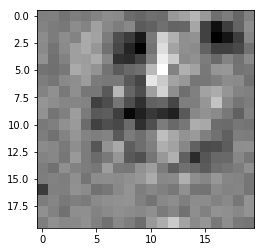

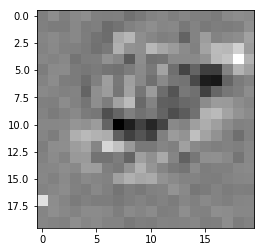

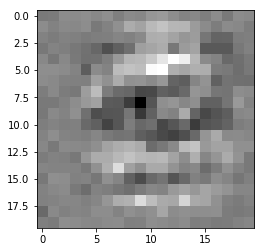

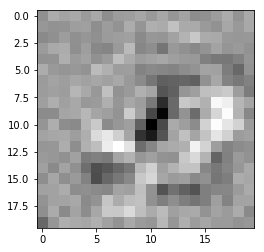

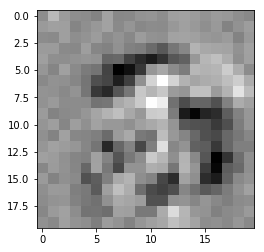

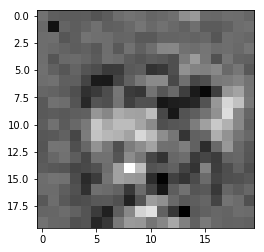

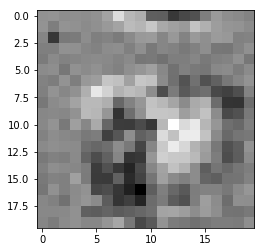

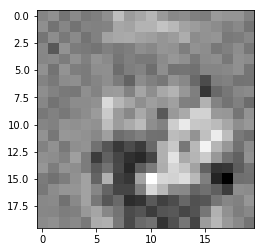

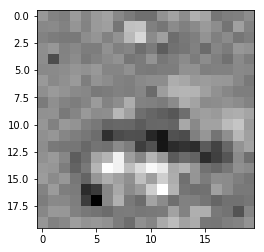

In [36]:
for i in range(25):
    if i>0:
        show_image(optimal_theta[i*400:(i+1)*400]) 

Just rewritted  what's above with some cleaning..  

In [37]:
def initialise_theta(number_theta, epsilon = 0.12):
    W = np.random.rand(number_theta)
    return W * 2 * epsilon - epsilon

In [38]:
def sigmoid(x):                                        
    return 1.0 / (1 + np.exp(-x))  

In [39]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1-sigmoid(z))

In [40]:
def h(theta1, theta2, x):
    z2 = theta1 @ x
    a2 = sigmoid(z2)
    
    #bias
    a2 = np.insert(a2, 0, 1, axis=0)
    
    z3 = theta2 @ a2
    a3 = sigmoid(z3)
    
    return a3, z3, a2, z2

In [41]:
def compute_cost_one_obs(theta1, theta2, y, x):
    k = - y * np.log(h(theta1, theta2, x)[0]) - (1 - y) *  np.log(1 - h(theta1, theta2, x)[0])
    return k.sum()

In [42]:
def gradient(theta, X, y, hidden_units, _lambda):
    
    # unroll and reshape theta
    m, n = X.shape
    k = y.shape[1]
    
    theta1 = theta[0:(n*hidden_units)].reshape(hidden_units, n)
    theta2 = theta[n*(hidden_units):].reshape(k, (hidden_units+1))     
    
    # intialise gradient to 0
    grad_theta1 = np.zeros(theta1.shape)
    grad_theta2 = np.zeros(theta2.shape)
    
    for i in range(m):
        a1 = X[i]
        
        # steps 1: forward propagation
        a3, z3, a2, z2 = h(theta1, theta2, X[i])
        z2 = np.insert(z2, 0, 1)
        
        # step 2: 'error' output layer       
        delta3 = a3 - y[i]

        # step 3: 'error' hidden layer 
        g2 = sigmoid_gradient(z2) 
        delta2 = (theta2.T @ delta3) * g2
           
        # step 4: accumulator
        grad_theta1 = grad_theta1 + (np.reshape(delta2[1:], (len(delta2[1:]),1)) * np.reshape(a1, (len(a1),1)).T)
        grad_theta2 = grad_theta2 + (np.reshape(delta3, (len(delta3),1)) * np.reshape(a2, (len(a2),1)).T)
        
    grad_theta = np.append(grad_theta1, grad_theta2) / m
    
    return grad_theta

In [43]:
def loss(theta, X, y, hidden_units, _lambda):
    
    # unroll and reshape theta
    m, n = X.shape
    k = y.shape[1]
    
    theta1 = theta[0:(n*hidden_units)].reshape(hidden_units, n)
    theta2 = theta[n*(hidden_units):].reshape(k, (hidden_units+1))  
    
    cost = 0

    for i in range(m):
        cost = cost + compute_cost_one_obs(theta1, theta2, y[i], X[i])
    
    reg = np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2)

    cost = (cost/m) + (_lambda/(2*m)) * reg
    
    return cost

In [44]:
def one_layer_neural_network(X, y, hidden_units=25):
    
    # intercept
    intercept = np.ones((len(X), 1))
    X = np.hstack((intercept, X)) 
    
    m, n = X.shape
    k = y.shape[1] 
    
    theta0 = initialise_theta(n*hidden_units+(hidden_units+1)*k)
    
    print('number of parameters:', theta0.shape)
    
    _lambda = 1
    
    result = op.minimize(fun=loss, x0=theta0, args=(X, y, hidden_units, _lambda), 
                        method='TNC', jac=gradient, options={'maxiter':10})
    
    return result.x

In [45]:
one_layer_neural_network(X, y_encoded, 10)

number of parameters: (4120,)


array([ 0.03137554, -0.04029693,  0.05724477, ..., -0.35487958,
       -0.15731899, -0.41668244])

**TODO**: 
- learn about ML and oriented object best practices -see existing library  
https://www.reddit.com/r/MachineLearning/comments/4kprfh/object_oriented_principlesbest_practices_for/

In [46]:
class one_layer_neural_network:
    def __init__(self, X, y, hidden_units=25):
        self.X = X
        self.y = y
        self.hidden_units = hidden_units
        self.m, self.n = X.shape
        self.k = y.shape[1]
        self.theta = initialise_theta((self.n+1)*hidden_units+(hidden_units+1)*self.k)
        
    def initialise_theta(number_theta, epsilon = 0.12):
        W = np.random.rand(number_theta)
        return W * 2 * epsilon - epsilon